In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Some import**

In [ ]:
import numpy as np
import pandas as pd
import sys
import random

from tqdm import tqdm

import re
import string

import os

import shutil

import json

## **Functions to parse data file**

In [ ]:
f_train = '/content/drive/MyDrive/data/simplified-nq-train.jsonl'
f_test = '/content/drive/MyDrive/data/simplified-nq-test.jsonl'
num_train_samples = 307372
num_test_samples = 346

In [ ]:
def parseData(set_id, filename=f_train, is_val=False, drop_noanswer_rate = 0.95, drop_null_instances_rate = 0.98, debug=False):
    INSTANCE_WORDS_LEN = 500 
    STRIDE = 256 
    num, count_drop, count_yes_no, count_long, count_short, count_no_answer = 0, 0, 0, 0, 0, 0
    list_instances = []
    with open(filename) as f:
        progress = tqdm(f, total=num_train_samples)  
        for sam_count, line in enumerate(progress):
            if sam_count >= num_train_samples:
                break
                
            data = json.loads(line)
            example_id = str(data['example_id'])
            if example_id in set_id:
                ans_id = data['annotations'][0]['long_answer']['candidate_index']
                if is_val == False and ans_id == -1:
                    # only keep 1 - drop_noanswer_rate of the negative sample
                    noans_rand = random.uniform(0, 1)
                    if noans_rand < drop_noanswer_rate: # drop this sample 
                        continue

                lan_start, lan_stop = -1, -1
                san_start, san_stop = -1, -1

                is_san = False
                is_drop = True # drop if the answer is too long
                
                num += 1
                lan_start = data['long_answer_candidates'][ans_id]['start_token']
                lan_stop = data['long_answer_candidates'][ans_id]['end_token']

                yes_no = data['annotations'][0]['yes_no_answer']
                if yes_no == "NONE":
                    is_yes_no = False
                else:
                    is_yes_no = True

                list_sans = data['annotations'][0]['short_answers']

                san_start, san_stop = lan_stop, lan_start

                for san in list_sans:
                    this_start, this_stop = san['start_token'], san['end_token']
                    if san_start > this_start: # start token should be smallest among short answers' start 
                        san_start = this_start
                    if san_stop < this_stop: # stop token should be largest among short answers' stop
                        san_stop = this_stop
                
                if san_start < san_stop:
                    is_san = True
        
                question = data['question_text'] # question

                doc_text = data['document_text']
                doc_split = doc_text.split()
                
                len_ques = len(question.split())
                part_len = INSTANCE_WORDS_LEN - len_ques 
                
                num_ins = (len(doc_split) - part_len)//STRIDE + 1

                for part_id in range(num_ins + 1):
                    part_start = part_id*STRIDE
                    part_stop = min(len(doc_split), part_id*STRIDE + part_len)
                    
                    part_split = doc_split[part_start:part_stop]
                    
                    part = ' '.join(part_split)
                    is_an_inside = False 
                    # for train file, check answer inside the instance 
                    if is_san: # if there is short answer for this doc
                        if san_start >= part_start and san_stop <= part_stop: # short answer is inside this part 
                            san_start_ins = san_start - part_start 
                            san_stop_ins = san_stop - part_start
                            target = 'SHORT'
                            count_short += 1

                            instance = {'example_id': example_id, 'part_id': part_id, 'question': question, 'context': part,
                                        'start': san_start_ins, 'stop': san_stop_ins, 'target': target}
                            list_instances.append(instance)

                            is_an_inside = True
                            is_drop = False
                            if debug:
                                if sam_count%5000 == 31:
                                    print(instance)

                    elif lan_stop - lan_start <= part_len: # long answer fits inside a part
                        if lan_start >= part_start and lan_stop <= part_stop: # long answer is inside this part 
                            lan_start_ins = lan_start - part_start
                            lan_stop_ins = lan_stop - part_start
                            target = 'LONG'

                            if is_yes_no:
                                target = yes_no
                                count_yes_no += 1
                            else:
                                count_long += 1

                            instance = {'example_id': example_id, 'part_id': part_id, 'question': question, 'context': part,
                                        'start': lan_start_ins, 'stop': lan_stop_ins, 'target': target}
                            list_instances.append(instance)
                            
                            is_an_inside = True
                            

                            if debug:
                                if sam_count%5000 == 31:
                                    print(instance)

                        is_drop = False

                    if not is_an_inside: # the case when no answer is inside this part
                        if not is_val:
                            null_ins_rand = random.uniform(0, 1)
                            if null_ins_rand < drop_null_instances_rate: # drop this instance 
                                continue
                        
                        count_no_answer += 1
                        instance = {'example_id': example_id, 'part_id': part_id, 'question': question,
                                    'context': part, 'start': 0, 'stop': 0, 'target': 'NO_ANSWER'}
                        list_instances.append(instance)
                        if debug:
                            if sam_count%5000 == 31:
                                print(instance)
                if is_drop:
                    count_drop += 1
    print("\n")
    print("NUM PROCESSED SAMPLES = ", num)
    print("NUM LONG ANSWER = ", count_long)
    print("NUM SHORT ANSWER = ", count_short)
    print("NUM YES NO ANSWER = ", count_yes_no)
    print("NUM NO ANSWER = ", count_no_answer)
    print("NUM DROP = ", count_drop)
    return list_instances

In [ ]:
df_train_id = pd.read_csv('/content/drive/MyDrive/data/fine_data/train_id.csv', dtype=str)
df_train_id.head()

,example_id
0,-565587030913118459
1,-6478192410479883355
2,4635878395292664241
3,-8606259257137055977
4,-370350151382095891


In [ ]:
set_train_id = set(df_train_id['example_id'].values.tolist())
print(len(set_train_id))

304299


In [ ]:
list_instances = parseData(set_train_id, drop_noanswer_rate=0.95, drop_null_instances_rate=0.985, debug=True)

  0%|          | 91/307372 [00:00<19:49, 258.43it/s]

{'example_id': '4706363175863681196', 'part_id': 0, 'question': 'when do the eclipse supposed to take place', 'context': 'Solar eclipse of August 21 , 2017 - Wikipedia <H1> Solar eclipse of August 21 , 2017 </H1> Jump to : navigation , search <Table> <Tr> <Th_colspan="2"> Solar eclipse of August 21 , 2017 </Th> </Tr> <Tr> <Td_colspan="2"> Totality as seen from Simpsonville , South Carolina </Td> </Tr> <Tr> <Td_colspan="2"> Map </Td> </Tr> <Tr> <Th_colspan="2"> Type of eclipse </Th> </Tr> <Tr> <Th> Nature </Th> <Td> Total </Td> </Tr> <Tr> <Th> Gamma </Th> <Td> 0.4367 </Td> </Tr> <Tr> <Th> Magnitude </Th> <Td> 1.0306 </Td> </Tr> <Tr> <Th_colspan="2"> Maximum eclipse </Th> </Tr> <Tr> <Th> Duration </Th> <Td> 160 sec ( 2 m 40 s ) </Td> </Tr> <Tr> <Th> </Th> <Td> 37 ° 00 ′ N 87 ° 42 ′ W \ufeff / \ufeff 37 ° N 87.7 ° W \ufeff / 37 ; - 87.7 </Td> </Tr> <Tr> <Th> Max . width of band </Th> <Td> 115 km ( 71 mi ) </Td> </Tr> <Tr> <Th_colspan="2"> Times ( UTC ) </Th> </Tr> <Tr> <Th> ( P1 ) Partial

  2%|▏         | 5170/307372 [00:09<05:55, 850.42it/s]

{'example_id': '1070150029854587994', 'part_id': 10, 'question': 'when is the last time the chargers made the playoffs', 'context': '<Td> 2005 </Td> <Td> NFL </Td> <Td> AFC </Td> <Td> West </Td> <Td> 3rd </Td> <Td> 9 </Td> <Td> 7 </Td> <Td> 0 </Td> <Td> </Td> <Td> Shawne Merriman ( DROY ) </Td> <Td> Marty Schottenheimer </Td> </Tr> <Tr> <Th> 2006 </Th> <Td> 2006 </Td> <Td> NFL </Td> <Td> AFC </Td> <Td> West </Td> <Td> 1st </Td> <Td> 14 </Td> <Td> </Td> <Td> 0 </Td> <Td> Lost Divisional Playoffs ( Patriots ) 21 -- 24 </Td> <Td> LaDainian Tomlinson ( MVP , OPOY ) </Td> <Td> Marty Schottenheimer </Td> </Tr> <Tr> <Th> 2007 </Th> <Td> 2007 </Td> <Td> NFL </Td> <Td> AFC </Td> <Td> West </Td> <Td> 1st </Td> <Td> 11 </Td> <Td> 5 </Td> <Td> 0 </Td> <Td> Won Wild Card Playoffs ( Titans ) 17 -- 6 Won Divisional Playoffs ( at Colts ) 28 -- 24 Lost AFC Championship ( at Patriots ) 12 -- 21 </Td> <Td> </Td> <Td> Norv Turner </Td> </Tr> <Tr> <Th> 2008 </Th> <Td> 2008 </Td> <Td> NFL </Td> <Td> AFC </T

  8%|▊         | 25161/307372 [00:37<05:29, 855.97it/s]

{'example_id': '5114648852222721674', 'part_id': 1, 'question': 'who did vanessa end up with in gossip girl', 'context': "as a recurring character , but became series regular after a successful run due to the popularity of their character , but left the series at the end of the fourth season . </P> <P> </P> <H2> Contents </H2> ( hide ) <Ul> <Li> 1 Novel series </Li> <Li> 2 Television series <Ul> <Li> 2.1 Casting </Li> <Li> 2.2 Characterization </Li> <Li> 2.3 Season 1 </Li> <Li> 2.4 Season 2 </Li> <Li> 2.5 Season 3 </Li> <Li> 2.6 Season 4 </Li> <Li> 2.7 Season 6 </Li> </Ul> </Li> <Li> 3 Reception </Li> <Li> 4 References </Li> </Ul> <P> </P> <H2> Novel series ( edit ) </H2> <P> Described as sullen , with a shaved head and black clothing , Vanessa is a budding filmmaker and Constance student on scholarship . Her dream is to one day attend NYU and major in film . Her hippie artist parents live in Vermont but allowed her to move to Williamsburg , Brooklyn to live with her sister Ruby . </P>

 10%|▉         | 30153/307372 [00:45<05:13, 884.43it/s]

{'example_id': '-4664379689749477533', 'part_id': 11, 'question': 'what treaty set up the league of nations', 'context': "intercourse with any part of the world and to use any force that may be necessary ... '' </P> <P> The two principal drafters and architects of the covenant of the League of Nations were the British politician Lord Robert Cecil and the South African statesman Jan Smuts . Smuts ' proposals included the creation of a Council of the great powers as permanent members and a non-permanent selection of the minor states . He also proposed the creation of a Mandate system for captured colonies of the Central Powers during the war . Cecil focused on the administrative side , and proposed annual Council meetings and quadrennial meetings for the Assembly of all members . He also argued for a large and permanent secretariat to carry out the League 's administrative duties . </P> <H3> Establishment ( edit ) </H3> The official opening of the League of Nations , 15 November 1920 <P>

 23%|██▎       | 70160/307372 [01:46<05:14, 755.15it/s]

{'example_id': '3150540880765930232', 'part_id': 7, 'question': 'who is the best nfl receiver of all time', 'context': 'Clark </Td> <Td> Wide receiver </Td> <Td> Washington Redskins ( 1985 -- 1992 ) Arizona / Phoenix Cardinals ( 1993 -- 1994 ) Miami Dolphins ( 1995 ) </Td> <Td> 699 </Td> <Td> 10,856 </Td> <Td> 15.5 </Td> </Tr> <Tr> <Td> 38 </Td> <Td> Stanley Morgan </Td> <Td> Wide receiver </Td> <Td> New England Patriots ( 1977 -- 1989 ) Indianapolis Colts ( 1990 ) </Td> <Td> 557 </Td> <Td> 10,716 </Td> <Td> 19.2 </Td> </Tr> <Tr> <Td> 39 </Td> <Td> Keyshawn Johnson </Td> <Td> Wide receiver </Td> <Td> New York Jets ( 1996 -- 1999 ) Tampa Bay Buccaneers ( 2000 -- 2003 ) Dallas Cowboys ( 2004 -- 2005 ) Carolina Panthers ( 2006 ) </Td> <Td> 814 </Td> <Td> 10,571 </Td> <Td> 13.0 </Td> </Tr> <Tr> <Td> 40 </Td> <Td> Harold Jackson </Td> <Td> Wide receiver </Td> <Td> Los Angeles Rams ( 1968 , 1973 -- 1977 ) Philadelphia Eagles ( 1969 -- 1972 ) New England Patriots ( 1978 -- 1981 ) Minnesota Vi

 24%|██▍       | 75192/307372 [01:54<04:35, 843.50it/s]

{'example_id': '-6992942632997814161', 'part_id': 2, 'question': 'who sang tale as old as time beauty and the beast 2017', 'context': "own , so they hired the more prominent Bryson to be her duet partner . At first Dion was also hesitant to record `` Beauty and the Beast '' because she had just recently been fired from recording the theme song of the animated film An American Tail : Fievel Goes West ( 1991 ) . First heard during the film 's end credits , the single was produced by Walter Afanasieff who also arranged it with Robbie Buchanan , and included on Dion 's self - titled album . The single was accompanied by a music video . Directed by Dominic Orlando , it combined footage of the singers recording the song at The Power Station with excerpts from the film . </P> <P> Both versions of `` Beauty and the Beast '' were very successful , garnering both a Golden Globe and Academy Award for Best Original Song , as well as Grammy Awards for Best Song Written for Visual Media and Best Pop

 26%|██▌       | 80119/307372 [02:01<04:31, 835.84it/s]

{'example_id': '4069289747244455141', 'part_id': 11, 'question': 'when did man utd last win premier league', 'context': "also won the Intercontinental Cup after beating Palmeiras 1 -- 0 in Tokyo . Ferguson was subsequently knighted for his services to football . </P> <P> Manchester United won the league again in the 1999 -- 2000 and 2000 -- 01 seasons . The team finished third in 2001 -- 02 , before regaining the title in 2002 -- 03 . They won the 2003 -- 04 FA Cup , beating Millwall 3 -- 0 in the final at the Millennium Stadium in Cardiff to lift the trophy for a record 11th time . In the 2005 -- 06 season , Manchester United failed to qualify for the knockout phase of the UEFA Champions League for the first time in over a decade , but recovered to secure a second - place league finish and victory over Wigan Athletic in the 2006 Football League Cup Final . The club regained the Premier League in the 2006 -- 07 and 2007 -- 08 seasons , and completed the European double by beating Chels

 33%|███▎      | 100200/307372 [02:30<04:03, 851.97it/s]

{'example_id': '687969463584927575', 'part_id': 0, 'question': 'vice president role as president of the senate', 'context': 'Vice president of the United States - wikipedia <H1> Vice president of the United States </H1> Jump to : navigation , search For a list of office - holders , see List of Vice Presidents of the United States . <Table> <Tr> <Th_colspan="2"> Vice President of the United States of America </Th> </Tr> <Tr> <Td_colspan="2"> Vice Presidential seal </Td> </Tr> <Tr> <Td_colspan="2"> Vice Presidential standard </Td> </Tr> <Tr> <Td_colspan="2"> Incumbent Mike Pence since January 20 , 2017 </Td> </Tr> <Tr> <Td_colspan="2"> Executive branch of the U.S. government Office of the Vice President </Td> </Tr> <Tr> <Th> Style </Th> <Td> Mr. Vice President ( Informal ) The Honorable ( Formal ) Mr. President ( When presiding over Senate ) His Excellency ( In international correspondence ) </Td> </Tr> <Tr> <Th> Member of </Th> <Td> Cabinet National Security Council President of the U.S

 41%|████      | 125175/307372 [03:08<04:01, 754.71it/s]

{'example_id': '-4508291966620018192', 'part_id': 0, 'question': 'where are the highest temperatures on earth recorded', 'context': "Highest temperature recorded on Earth - wikipedia <H1> Highest temperature recorded on Earth </H1> Furnace Creek Ranch , the location of the highest recording <P> According to the World Meteorological Organization ( WMO ) , the highest confirmed air temperature on Earth was 56.7 ° C ( 134.1 ° F ) in Furnace Creek Ranch , California , located in the Death Valley desert in the United States , on July 10 , 1913 . While measuring air temperature is standard , there are two other main ways that a temperature can be recorded . </P> <H2> Contents </H2> ( hide ) <Ul> <Li> 1 Measurements <Ul> <Li> 1.1 Air and ground temperature </Li> <Li> 1.2 Satellite measurements </Li> </Ul> </Li> <Li> 2 Unverified claims </Li> <Li> 3 See also </Li> <Li> 4 References </Li> </Ul> <H2> Measurements ( edit ) </H2> <H3> Air and ground temperature ( edit ) </H3> <P> The standard meas

 42%|████▏     | 130130/307372 [03:15<04:14, 696.24it/s]

{'example_id': '495212879734966266', 'part_id': 1, 'question': 'when did harry potter and the deathly hallows part 1 come out', 'context': "<Th> Release date </Th> <Td> <Ul> <Li> 11 November 2010 ( 2010 - 11 - 11 ) ( Odeon Leicester Square ) </Li> <Li> 19 November 2010 ( 2010 - 11 - 19 ) ( United Kingdom & United States ) </Li> <Li> </Li> <Li> </Li> <Li> </Li> </Ul> </Td> </Tr> <Tr> <Th> Running time </Th> <Td> 146 minutes </Td> </Tr> <Tr> <Th> Country </Th> <Td> <Ul> <Li> United Kingdom </Li> <Li> United States </Li> </Ul> </Td> </Tr> <Tr> <Th> Language </Th> <Td> English </Td> </Tr> <Tr> <Th> Budget </Th> <Td> $250 million ( Shared with Part 2 ) </Td> </Tr> <Tr> <Th> Box office </Th> <Td> $960.3 million </Td> </Tr> </Table> <P> Harry Potter and the Deathly Hallows -- Part 1 is a 2010 British - American fantasy film directed by David Yates and distributed by Warner Bros. Pictures . It is the first of two cinematic parts based on the novel of the same name by J.K. Rowling and features 

 44%|████▍     | 135090/307372 [03:23<04:07, 695.53it/s]

{'example_id': '2498612561136094537', 'part_id': 0, 'question': 'when was the last time lsu beat alabama', 'context': 'Alabama -- LSU football rivalry - wikipedia <H1> Alabama -- LSU football rivalry </H1> Jump to : navigation , search <Table> Alabama -- LSU football rivalry <Tr> <Td_colspan="2"> <Table> <Tr> <Td> Alabama Crimson Tide </Td> <Td> LSU Tigers </Td> </Tr> </Table> </Td> </Tr> <Tr> <Th> First meeting </Th> <Td> November 18 , 1895 LSU 12 , Alabama 6 </Td> </Tr> <Tr> <Th> Latest meeting </Th> <Td> November 4 , 2017 Alabama 24 , LSU 10 </Td> </Tr> <Tr> <Th> Next meeting </Th> <Td> November 3 , 2018 </Td> </Tr> <Tr> <Th_colspan="2"> Statistics </Th> </Tr> <Tr> <Th> Meetings total </Th> <Td> 82 </Td> </Tr> <Tr> <Th> All - time series </Th> <Td> Alabama leads , 52 -- 25 -- 5 </Td> </Tr> <Tr> <Th> Largest victory </Th> <Td> Alabama , 47 -- 3 ( 1922 ) </Td> </Tr> <Tr> <Th> Longest win streak </Th> <Td> Alabama , 11 ( 1971 -- 81 ) </Td> </Tr> <Tr> <Th> Current win streak </Th> <Td> 

 46%|████▌     | 140084/307372 [03:31<07:26, 375.06it/s]

{'example_id': '3742935087110920859', 'part_id': 8, 'question': 'where was opening scene of sound of music filmed', 'context': "producer Wolfgang Liebeneiner purchased the film rights for $9,000 ( equivalent to $81,000 in 2017 ) , hired George Hurdalek and Herbert Reinecker to write the screenplay , and Franz Grothe to supervise the soundtrack , which consisted of traditional Austrian folk songs . The Trapp Family was released in West Germany on October 9 , 1956 and became a major success . Two years later , Liebeneiner directed a sequel , The Trapp Family in America , and the two pictures became the most successful films in West Germany during the post-war years . Their popularity extended throughout Europe and South America . </P> <P> In 1956 , Paramount Pictures purchased the United States film rights , intending to produce an English - language version with Audrey Hepburn as Maria . The studio eventually dropped its option , but one of its directors , Vincent J. Donehue , proposed 

 49%|████▉     | 150129/307372 [03:47<05:20, 490.60it/s]

{'example_id': '6586844464296767987', 'part_id': 13, 'question': 'what is the prize for winning the national spelling bee', 'context': "81st Competition </Td> </Tr> <Tr> <Td> 2009 </Td> <Td> 82nd Competition </Td> </Tr> <Tr> <Td> </Td> <Td> 83rd Competition </Td> </Tr> <Tr> <Td> 2011 </Td> <Td> 84th Competition </Td> </Tr> <Tr> <Td> 2012 </Td> <Td> 85th Competition </Td> </Tr> <Tr> <Td> 2013 </Td> <Td> 86th Competition </Td> </Tr> <Tr> <Td> 2014 </Td> <Td> 87th Competition </Td> </Tr> <Tr> <Td> 2015 </Td> <Td> 88th Competition </Td> </Tr> <Tr> <Td> 2016 </Td> <Td> 89th Competition </Td> </Tr> <Tr> <Td> 2017 </Td> <Td> 90th Competition </Td> </Tr> </Table> <H2> Proposed international Bee ( edit ) </H2> <P> In May 2012 , Scripps announced tentative plans for an international version , in which three - person teams from as many as sixty countries would compete . Although each speller would be able to confer with teammates once during each contest , all spellers would eventually compete an

 50%|█████     | 155138/307372 [03:55<04:01, 629.86it/s]

{'example_id': '5747816612116381690', 'part_id': 8, 'question': "who got eliminated today in india's next superstar", 'context': '<Td> 7 </Td> <Td> 14 </Td> <Td> 12 </Td> <Td> 13 </Td> <Td> 6 + 3 = 9 </Td> <Td_colspan="7"> ELIMINATED </Td> <Td> 55 </Td> </Tr> <Tr> <Td> Pranati Rai Prakash </Td> <Td> 7 </Td> <Td> 13 </Td> <Td> 17 </Td> <Td> 14 </Td> <Td> 6 + 3 = 9 </Td> <Td_colspan="7"> ELIMINATED </Td> <Td> 60 </Td> </Tr> <Tr> <Th> 10 </Th> <Td> Jash Bahl </Td> <Td> 10 </Td> <Td> 14 </Td> <Td> 12 </Td> <Td_colspan="9"> ELIMINATED </Td> <Td> 36 </Td> </Tr> <Tr> <Td> Heli Vyas </Td> <Td> 6 </Td> <Td> 12 </Td> <Td> 12 </Td> <Td_colspan="9"> ELIMINATED </Td> <Td> 30 </Td> </Tr> <Tr> <Th> 11 </Th> <Td> Shivank Chaudhary </Td> <Td> 6 </Td> <Td> 12 </Td> <Td_colspan="10"> ELIMINATED </Td> <Td> 18 </Td> </Tr> <Tr> <Td> Sahiba Bhasin </Td> <Td> 7 </Td> <Td> 12 </Td> <Td_colspan="10"> ELIMINATED </Td> <Td> 19 </Td> </Tr> <Tr> <Th> 12 </Th> <Td> Karanraj Sharma </Td> <Td> 6 </Td> <Td_colspan="11"

 54%|█████▎    | 165171/307372 [04:10<03:11, 741.84it/s]

{'example_id': '-6551565981725074825', 'part_id': 12, 'question': 'who is the home team for the super bowl', 'context': "the Atlanta Falcons 15 -- 10 , by stopping the Falcons on four consecutive plays after they had a first - down - and - goal situation on the Eagles 9 - yard line during their final drive . They then soundly defeated the Minnesota Vikings 38 -- 7 in the NFC Championship Game . Despite the Vikings scoring on their opening drive , the Eagles defense held them to three punts , two turnovers on downs , two interceptions , and one lost fumble in their remaining drives of the game . Meanwhile , Foles had a great game in which he completed 26 of 33 passes for 353 yards and three touchdowns . </P> <H3> Pregame notes ( edit ) </H3> <P> This game was a rematch of Super Bowl XXXIX . Only one player , Patriots starting quarterback Tom Brady , remained on either roster from that contest . Bill Belichick , the Patriots ' head coach in that contest , also remained in that position .

 55%|█████▌    | 170151/307372 [04:17<02:34, 888.17it/s]

{'example_id': '6797737124125700662', 'part_id': 14, 'question': 'when did the country of kenya come into existence', 'context': "were already home to over a million members of the Kikuyu people , most of whom had no land claims in European terms and lived as itinerant farmers . To protect their interests , the settlers banned the growing of coffee , introduced a hut tax , and the landless were granted less and less land in exchange for their labour . A massive exodus to the cities ensued as their ability to provide a living from the land dwindled . There were 80,000 white settlers living in Kenya in the 1950s . </P> <P> Throughout World War II , Kenya was an important source of manpower and agriculture for the United Kingdom . Kenya itself was the site of fighting between Allied forces and Italian troops in 1940 -- 41 when Italian forces invaded . Wajir and Malindi were bombed as well . </P> <P> In 1952 , Princess Elizabeth and her husband Prince Philip were on holiday at the Treetops

 57%|█████▋    | 175194/307372 [04:25<02:36, 846.89it/s]

{'example_id': '-1936620480520412765', 'part_id': 0, 'question': "who sang you'll never walk alone first liverpool or celtic", 'context': 'You \'ll Never Walk Alone - wikipedia <H1> You \'ll Never Walk Alone </H1> For other uses , see You \'ll Never Walk Alone ( disambiguation ) . <Table> <Tr> <Th_colspan="2"> `` You \'ll Never Walk Alone \'\' </Th> </Tr> <Tr> <Th_colspan="2"> Song </Th> </Tr> <Tr> <Th> Published </Th> <Td> 1945 </Td> </Tr> <Tr> <Th> Genre </Th> <Td> Show tune </Td> </Tr> <Tr> <Th> Composer ( s ) </Th> <Td> Richard Rodgers </Td> </Tr> <Tr> <Th> Lyricist ( s ) </Th> <Td> Oscar Hammerstein II </Td> </Tr> </Table> <P> `` You \'ll Never Walk Alone \'\' is a show tune from the 1945 Rodgers and Hammerstein musical Carousel . In the second act of the musical , Nettie Fowler , the cousin of the protagonist Julie Jordan , sings `` You \'ll Never Walk Alone \'\' to comfort and encourage Julie when her husband , Billy Bigelow , the male lead , commits suicide after a failed robbe

 60%|██████    | 185134/307372 [04:40<02:29, 819.42it/s]

{'example_id': '-7307624958962961283', 'part_id': 0, 'question': 'who played germany in the world cup 2014', 'context': '2014 FIFA World Cup final - wikipedia <H1> 2014 FIFA World Cup final </H1> Jump to : navigation , search <Table> 2014 FIFA World Cup Final <Tr> <Td_colspan="2"> Germany \'s Mario Götze scores the match - winning goal in the 113th minute </Td> </Tr> <Tr> <Th> Event </Th> <Td> 2014 FIFA World Cup </Td> </Tr> <Tr> <Td_colspan="2"> <Table> <Tr> <Th> Germany </Th> <Th> Argentina </Th> </Tr> <Tr> <Th> </Th> <Th> </Th> </Tr> <Tr> <Th> </Th> <Th> 0 </Th> </Tr> </Table> </Td> </Tr> <Tr> <Td_colspan="2"> After extra time </Td> </Tr> <Tr> <Th> Date </Th> <Td> 13 July 2014 ( 2014 - 07 - 13 ) </Td> </Tr> <Tr> <Th> Venue </Th> <Td> Maracanã Stadium , Rio de Janeiro </Td> </Tr> <Tr> <Th> Man of the Match </Th> <Td> Mario Götze ( Germany ) </Td> </Tr> <Tr> <Th> Referee </Th> <Td> Nicola Rizzoli ( Italy ) </Td> </Tr> <Tr> <Th> Attendance </Th> <Td> 74,738 </Td> </Tr> <Tr> <Th> Weathe

 62%|██████▏   | 190168/307372 [04:47<02:15, 864.36it/s]

{'example_id': '710977160724852095', 'part_id': 0, 'question': 'how many episodes of broad city in season 4', 'context': 'List of Broad City episodes - wikipedia <H1> List of Broad City episodes </H1> Jump to : navigation , search <P> Broad City is an American comedy series that premiered on January 22 , 2014 on Comedy Central . The series was created by and stars Ilana Glazer and Abbi Jacobson as two best friends who navigate everyday life in New York City . </P> <P> </P> <H2> Contents </H2> ( hide ) <Ul> <Li> 1 Series overview </Li> <Li> 2 Episodes <Ul> <Li> 2.1 Season 1 ( 2014 ) </Li> <Li> 2.2 Season 2 ( 2015 ) </Li> <Li> 2.3 Season 3 ( 2016 ) </Li> <Li> 2.4 Season 4 ( 2017 ) </Li> </Ul> </Li> <Li> 3 Ratings </Li> <Li> 4 References </Li> <Li> 5 External links </Li> </Ul> <P> </P> <H2> Series overview ( edit ) </H2> <Table> <Tr> <Th_colspan="2"> Season </Th> <Th_colspan="2"> Episodes </Th> <Th_colspan="2"> Originally aired </Th> </Tr> <Tr> <Th> First aired </Th> <Th> Last aired </Th>

 65%|██████▌   | 200148/307372 [05:02<02:27, 727.29it/s]

{'example_id': '7669023380313448789', 'part_id': 15, 'question': 'when the federal government creates a law the produces costs for the states it must', 'context': "small portion of spending in Function 650 - the general fund transfer of income taxes on Social Security benefits - is considered on - budget and appears in the budget resolution totals . </Td> </Tr> <Tr> <Td> 700 </Td> <Td> Veterans Benefits and Services </Td> <Td> Function 700 covers the programs of the Department of Veterans Affairs ( VA ) , including veterans ' medical care , compensation and pensions , education and rehabilitation benefits , and housing programs . It also includes the Department of Labor 's Veterans ' Employment and Training Service , the United States Court of Appeals for Veterans Claims , and the American Battle Monuments Commission . Almost 90 percent of appropriated funding in Function 700 goes to veterans ' health care . </Td> </Tr> <Tr> <Td> 750 </Td> <Td> Administration of Justice </Td> <Td> The 

 73%|███████▎  | 225144/307372 [05:48<01:44, 786.26it/s]

{'example_id': '1772723147071903143', 'part_id': 11, 'question': "who did joey end up with on dawson's creek", 'context': "loses his entire investment , Joey decides that it 's time they worked things out for themselves without her in the middle because it `` is not her fight '' and that it never has been , and never will be . After a heart to heart with Pacey on the dock , Joey brings everyone together to help Dawson make his movie . Joey finally goes to Paris and the final episode of the season ends with her standing before the famous Eiffel Tower . </P> Series finale ( edit ) <P> The final two episodes are set approximately five years after the season finale . Joey is a junior editor living in New York with her writer boyfriend , Christopher ( Jeremy Sisto ) . During this double episode , the five friends return to Capeside for Gail Leery 's third wedding ( but second husband ) . Although she had originally planned to spend the weekend with Christopher , Joey runs scared after findi

 75%|███████▍  | 230081/307372 [05:56<02:19, 552.80it/s]

{'example_id': '7128920655291034805', 'part_id': 0, 'question': 'when were the moors pushed out of spain', 'context': "Moors - Wikipedia <H1> Moors </H1> Jump to : navigation , search This article is about a historical group of Muslims . For other uses , see Moor . Castillian ambassadors attempting to convince Moorish Almohad king Abu Hafs Umar al - Murtada to join their alliance ( contemporary depiction from the Cantigas de Santa María ) <P> The term `` Moors '' refers primarily to the Muslim inhabitants of the Maghreb , the Iberian Peninsula , Sicily , and Malta during the Middle Ages . The Moors initially were the Berber autochthones of the Maghreb . The name was later also applied to Arabs . </P> <P> Moors are not a distinct or self - defined people , and the 1911 Encyclopaedia Britannica observed that `` The term ' Moors ' has no real ethnological value . '' Medieval and early modern Europeans variously applied the name to Arabs , North African Berbers , and Muslim Europeans . </P

 76%|███████▋  | 235056/307372 [06:05<05:23, 223.58it/s]

{'example_id': '478617815553486450', 'part_id': 6, 'question': 'where does the name green bay packers come from', 'context': "the playoffs </Li> <Li> 1.8. 3 2010 : Super Bowl XLV championship </Li> <Li> 1.8. 4 2011 : 15 -- 1 season </Li> <Li> 1.8. 5 2012 </Li> <Li> 1.8. 6 2013 : injury to Rodgers </Li> <Li> 1.8. 7 2014 </Li> <Li> 1.8. 8 2015 </Li> <Li> 1.8. 9 2016 </Li> <Li> 1.8. 10 2017 </Li> </Ul> </Li> </Ul> </Li> <Li> 2 Community ownership <Ul> <Li> 2.1 Board of Directors </Li> <Li> 2.2 Green Bay Packers Foundation </Li> </Ul> </Li> <Li> 3 Fan base </Li> <Li> 4 Branding <Ul> <Li> 4.1 Nickname </Li> <Li> 4.2 Team colors </Li> <Li> 4.3 Logo </Li> <Li> 4.4 Uniform variation </Li> </Ul> </Li> <Li> 5 Stadium history </Li> <Li> 6 Statistics and records <Ul> <Li> 6.1 Season - by - season results </Li> <Li> 6.2 Records </Li> <Li> 6.3 Playoff record </Li> </Ul> </Li> <Li> 7 Championships <Ul> <Li> 7.1 League Championships <Ul> <Li> 7.1. 1 NFL Championship by standings </Li> <Li> 7.1. 2 Pre-

 78%|███████▊  | 240176/307372 [06:13<01:48, 618.67it/s]

{'example_id': '1136650406758304579', 'part_id': 1, 'question': 'what is the point of a semi hollow guitar', 'context': "jazz bands . This led makers to try a series of designs that focused on amplifying a guitar electrically through a loudspeaker . In 1936 , Gibson made their first production run of electric guitars . These guitars , known as ES - 150s ( Electric Spanish Series ) were the first manufactured semi-acoustic guitars . </P> <P> Gibson based them on a standard production archtop , with f holes on the face of the guitar 's soundbox . This model resembled traditional jazz guitars that were popular at the time . The soundbox on the guitar let limited sound emit from the hollow body of the guitar . These guitars , however , could be electrically amplified via a Charlie Christian pickup , a magnetic single - coil pickup that converted the energy of the vibrating strings into an electrical signal . The clear sound of the pickups made the ES series immediately popular with jazz mu

 81%|████████▏ | 250124/307372 [06:28<01:13, 779.86it/s]

{'example_id': '6045170630013492137', 'part_id': 0, 'question': 'where did the windows xp background come from', 'context': 'Bliss ( image ) - wikipedia <H1> Bliss ( image ) </H1> Jump to : navigation , search For other uses , see Bliss ( disambiguation ) . <Table> <Tr> <Th_colspan="2"> Bliss </Th> </Tr> <Tr> <Td_colspan="2"> </Td> </Tr> <Tr> <Th> Artist </Th> <Td> Charles O\'Rear </Td> </Tr> <Tr> <Th> Year </Th> <Td> </Td> </Tr> <Tr> <Th> Type </Th> <Td> Landscape photography </Td> </Tr> <Tr> <Th> Location </Th> <Td> Sonoma County , California , United States </Td> </Tr> <Tr> <Th> Coordinates </Th> <Td> 38 ° 15 ′ 00.5 \'\' N 122 ° 24 ′ 38.9 \'\' W \ufeff / \ufeff 38.250139 ° N 122.410806 ° W \ufeff / 38.250139 ; - 122.410806 Coordinates : 38 ° 15 ′ 00.5 \'\' N 122 ° 24 ′ 38.9 \'\' W \ufeff / \ufeff 38.250139 ° N 122.410806 ° W \ufeff / 38.250139 ; - 122.410806 </Td> </Tr> <Tr> <Th> Owner </Th> <Td> Microsoft </Td> </Tr> </Table> <P> Bliss is the name of the default computer wallpaper 

 83%|████████▎ | 255103/307372 [06:35<01:04, 805.87it/s]

{'example_id': '-2153209466801675763', 'part_id': 6, 'question': 'when was the first full suspension mountain bike made', 'context': "Others such as Proflex ( Girvin ) , Whyte and BMW , have made suspension forks that employ four - bar linkage systems instead of relying upon telescopic fork legs , much like BMW 's Duolever . The Suntour Swing Shock fork is based on a coil cantilevered swing set - up , and suspension is given by a coil spring which is located within the steerer tube and can be accessed from the top , technology which was originally used for suspension on early motorcycles . </P> <P> To prevent water and dirt from damaging the suspension , gaiters have been used to cover the fork 's stanchions . However even when properly sealing the stanchions and sliders , the gaiters have to have small openings in them to allow air to move in and out of the cavity between gaiter and stanchion as the fork moves through its travel . Some water and grit may find its way in through these 

 85%|████████▍ | 260177/307372 [06:43<01:04, 730.96it/s]

{'example_id': '4923162857637513684', 'part_id': 0, 'question': 'how many stars is there in the american flag', 'context': 'Flag of the United States - wikipedia <H1> Flag of the United States </H1> Jump to : navigation , search `` American Flag \'\' and `` Flag of the USA \'\' redirect here . For other uses , see American Flag ( disambiguation ) . For the flag of the Union of South Africa , see Flag of South Africa ( 1928 -- 1994 ) . <Table> United States of America <Tr> <Td_colspan="2"> </Td> </Tr> <Tr> <Td_colspan="2"> </Td> </Tr> <Tr> <Th> Names </Th> <Td> The American flag , The Stars and Stripes ; Red , White , and Blue ; Old Glory ; The Star - Spangled Banner ; US flag ; United States flag </Td> </Tr> <Tr> <Th> Use </Th> <Td> National flag and ensign </Td> </Tr> <Tr> <Th> Proportion </Th> <Td> 10 : 19 </Td> </Tr> <Tr> <Th> Adopted </Th> <Td> <Ul> <Li> June 14 , 1777 ( original 13 - star version ) </Li> <Li> July 4 , 1960 ( current 50 - star version ) </Li> </Ul> </Td> </Tr> <Tr>

 88%|████████▊ | 270169/307372 [06:58<00:46, 806.85it/s]

{'example_id': '-7551214705282176526', 'part_id': 2, 'question': 'when is series 3 of 800 words being aired', 'context': "</Li> </Ul> </Li> <Li> 6 Viewership <Ul> <Li> 6.1 Season 1 ( 2015 ) </Li> <Li> 6.2 Season 2 ( 2016 -- 17 ) </Li> <Li> 6.3 Season 3 ( 2017 ) </Li> </Ul> </Li> <Li> 7 Remake </Li> <Li> 8 References </Li> <Li> 9 External links </Li> </Ul> <P> </P> <H2> Production ( edit ) </H2> <P> The series was first announced on 29 October 2014 with the Channel Seven 2015 highlights . The CEO of South Pacific Pictures , Kelly Martin said `` Seven loved the scripts from the start and we 're thrilled to have this project underway . It enables South Pacific Pictures to broaden our horizons and it 'll open up some great opportunities for our local actors and crew . '' Of the series ' tone , the Program Chief of Seven , Tim Ross stated , `` If you think this show has a bit of the same feel and vibe as Packed to the Rafters , you 're dead right -- and we make no apologies for that . '' Fi

 90%|████████▉ | 275162/307372 [07:06<00:40, 800.34it/s]

{'example_id': '-9144689914720422706', 'part_id': 0, 'question': "who wrote and sang when i'm 64", 'context': 'When I \'m Sixty - Four - wikipedia <H1> When I \'m Sixty - Four </H1> `` When I \'m 64 \'\' redirects here . For the 2004 television film , see When I \'m 64 ( film ) . <P> </P> <Table> <Tr> <Th_colspan="2"> `` When I \'m Sixty - Four \'\' </Th> </Tr> <Tr> <Td_colspan="2"> The 1996 US jukebox single release of the song , as the B - side to `` Lucy in the Sky with Diamonds \'\' </Td> </Tr> <Tr> <Th_colspan="2"> Song by the Beatles </Th> </Tr> <Tr> <Th_colspan="2"> from the album Sgt . Pepper \'s Lonely Hearts Club Band </Th> </Tr> <Tr> <Th> Released </Th> <Td> 26 May 1967 </Td> </Tr> <Tr> <Th> Recorded </Th> <Td> 6 -- 21 December 1966 , EMI Studios , London </Td> </Tr> <Tr> <Th> Genre </Th> <Td> <Ul> <Li> Pop </Li> <Li> music hall </Li> </Ul> </Td> </Tr> <Tr> <Th> Length </Th> <Td> 2 : 37 </Td> </Tr> <Tr> <Th> Label </Th> <Td> Parlophone </Td> </Tr> <Tr> <Th> Songwriter ( s ) 

 91%|█████████ | 280159/307372 [07:14<00:37, 718.03it/s]

{'example_id': '-2451547781743155006', 'part_id': 0, 'question': 'who is the longest serving prisoner in the uk', 'context': "List of prisoners with whole - life orders - wikipedia <H1> List of prisoners with whole - life orders </H1> Jump to : navigation , search <Table> <Tr> <Td> </Td> <Td> This article needs additional citations for verification . Please help improve this article by adding citations to reliable sources . Unsourced material may be challenged and removed . ( September 2009 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> <P> This is a list of prisoners who have received a whole - life order through some mechanism in jurisdictions of the United Kingdom . It has been reportedly issued in approximately 100 cases since its introduction in 1983 , although a significant percentage of these prisoners have since died in custody , or had their sentences reduced on appeal . There are now believed to be at least 68 prisoners currently serving whole l

100%|██████████| 307372/307372 [07:56<00:00, 644.61it/s]




NUM PROCESSED SAMPLES =  158292
NUM LONG ANSWER =  55853
NUM SHORT ANSWER =  168904
NUM YES NO ANSWER =  4429
NUM NO ANSWER =  107250
NUM DROP =  7301


In [ ]:
random.shuffle(list_instances)
list_instances_df = pd.DataFrame(list_instances)
list_instances_df.head()

,example_id,part_id,question,context,start,stop,target
0,-4279301782730399041,1,who sings lead vocals on love will keep us alive,"their `` Hell Freezes Over '' reunion tour , w...",14,17,SHORT
1,-7304168693209096798,2,who plays the little boy in the sixth sense,"at the age of four , when his mother took him ...",275,449,LONG
2,693096848741056682,0,when was the last episode of pretty little lia...,List of Pretty Little Liars episodes - wikiped...,442,446,SHORT
3,-4939544960366533655,2,who played justin starr on shake it up,and `` Wild Christmas '' for School 's Out ! C...,199,294,LONG
4,-6724353270824878554,2,who provided the voice of the geico insurance ...,Forward </Li> <Li> 24 Surprising <Ul> <Li> 24....,306,309,SHORT


In [ ]:
list_instances_df.to_csv('/content/drive/MyDrive/data/fine_data/train_instance_256.csv', index=False, 
                         columns=['example_id', 'part_id', 'question', 'context', 'start', 'stop', 'target'])

## **Handle validation set**

In [ ]:
df_val_id = pd.read_csv('/content/drive/MyDrive/data/fine_data/val_id.csv', dtype=str)
df_val_id.head()

,example_id
0,-4415223548557328381
1,-706775569507012323
2,-8247431609310444236
3,178097630653295544
4,7206764020223190386


In [ ]:
set_val_id = set(df_val_id['example_id'].values.tolist())
print(len(set_val_id))

3075


In [ ]:
list_val_instances = parseData(set_val_id, is_val=True, debug=True)

100%|██████████| 307372/307372 [04:41<00:00, 1090.02it/s]



NUM PROCESSED SAMPLES =  3075
NUM LONG ANSWER =  3958
NUM SHORT ANSWER =  2211
NUM YES NO ANSWER =  56
NUM NO ANSWER =  135977
NUM DROP =  76


In [ ]:
# random.shuffle(list_val_instances)
list_val_instances_df = pd.DataFrame(list_val_instances)
list_val_instances_df.head(100)

,example_id,part_id,question,context,start,stop,target
0,4158175306918787233,0,the most common system of land title in australia,Torrens title - wikipedia <H1> Torrens title <...,408,410,SHORT
1,4158175306918787233,1,the most common system of land title in australia,conversion </Li> <Li> Action to quiet title </...,216,218,SHORT
2,4158175306918787233,2,the most common system of land title in australia,</Ul> Higher category : Law and Common law </T...,24,26,SHORT
3,4158175306918787233,3,the most common system of land title in australia,"other interests , including credit interests (...",0,0,NO_ANSWER
4,4158175306918787233,4,the most common system of land title in australia,the principle of `` title by registration '' (...,0,0,NO_ANSWER
...,...,...,...,...,...,...,...
95,-1957133654292017851,62,will xbox 360 disc work on xbox one,<Td> XBLA </Td> <Td> </Td> <Td> 000000002015 -...,0,0,NO_ANSWER
96,-1957133654292017851,63,will xbox 360 disc work on xbox one,Perfect Dark Zero </Td> <Td> Microsoft Studios...,0,0,NO_ANSWER
97,-1957133654292017851,64,will xbox 360 disc work on xbox one,in the Vault of EA Access . </Td> </Tr> <Tr> <...,0,0,NO_ANSWER
98,-1957133654292017851,65,will xbox 360 disc work on xbox one,Squad </Td> <Td> System 3 Software Limited </T...,0,0,NO_ANSWER


In [ ]:
list_val_instances_df.to_csv('/content/drive/MyDrive/data/fine_data/val_instance_192.csv', index=False, 
                         columns=['example_id', 'part_id', 'question', 'context', 'start', 'stop', 'target'])

## **Handle squad dataset**

In [ ]:
squad_train = '/content/drive/MyDrive/data/train-v2.0.json'

In [ ]:
def squad_json_to_dataframe_train(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1])
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

## **Functions to tokenize data**

In [ ]:
AnswerType = {
    'NO_ANSWER': 0,
    'YES': 1,
    'NO': 2,
    'SHORT' : 3,
    'LONG' : 4
}

def find_ans_loc(context, ans, ans_start, context_words): 
    new_loc = 0
    for c in context[0:int(ans_start)]:
        if c.isspace():
            new_loc += 1

    new_length = 1
    for c in ans:
        if c.isspace():
            new_length += 1

    # print(ans, context_words[new_loc:new_loc + new_length])
    return new_loc, new_length

def preprocess_lan_data(data, tokenizer): # without target 
    progress = tqdm(data, total=len(data))
    x1 = []
    x2 = []
    x3 = []
    y = []
    for one_sam in progress:
        tokenized_sam = tokenizer.encode_plus(one_sam['question'], one_sam['context'], 
                                              padding='max_length',
                                              truncation=True,
                                              max_length=512,
                                              add_special_tokens=True)
        x1.append(tf.cast(tokenized_sam['input_ids'], tf.int32))
        x2.append(tf.cast(tokenized_sam['token_type_ids'], tf.int32))
        x3.append(tf.cast(tokenized_sam['attention_mask'], tf.int32))

        # y.append([one_sam['start'], one_sam['stop'], AnswerType[one_sam['target']]])
        y.append([one_sam['start'], one_sam['stop']])
    return x1, x2, x3, y

def preprocess_squad(df, tokenizer):
    x1 = []
    x2 = []
    x3 = []
    y = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        context = row['context']
        question = row['question']
        question = question[0:len(question) - 1] # drop the question mark

        if len(context.split()) >= 500 - len(question.split()):
            # drop too large context
            continue
        
        # print(question, context)
        tokenized_sam = tokenizer.encode_plus(question, context, 
                                              padding='max_length',
                                              truncation=True,
                                              max_length=512,
                                              add_special_tokens=True)
        
        x1.append(tf.cast(tokenized_sam['input_ids'], tf.int32))
        x2.append(tf.cast(tokenized_sam['token_type_ids'], tf.int32))
        x3.append(tf.cast(tokenized_sam['attention_mask'], tf.int32))

        no_ans = row['no_answer']
        if no_ans:
            # in case of no answer, start = 0, stop = 0, AnswerType = 0
            # y.append([0, 0, 0])
            y.append([0, 0])
        else:
            ans = row['text']
            # print(ans)
            lower_ans = ans.lower()
            context_words = context.split()
            if lower_ans == 'no': # for yes, no question, start = 1 and stop = end of the context 
                start = 1
                stop = len(context_words) - 1
                target = 2
                # target = 0 # not consider target while train squad
                # y.append([start, stop, target])
                y.append([start, stop])

            else: # for normal question
                ans_start = int(row['answer_start'])
                loc, length = find_ans_loc(context, ans, ans_start, context_words)
                start = loc
                stop = loc + length 
                target = 3 # consider as short answer 
                # target = 0 # not consider target while train squad 
                # y.append([start, stop, target])
                y.append([start, stop])

    if len(x1) != len(y):
        print("ERROR: Length of data mismatched")
        return
    return x1, x2, x3, y

## **Functions to get strategy**

In [ ]:
def get_strategy():
    try:
        tpu_cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu_cluster_resolver.cluster_spec().as_dict()['worker'])
        tf.config.experimental_connect_to_cluster(tpu_cluster_resolver)
        tf.tpu.experimental.initialize_tpu_system(tpu_cluster_resolver)
        strategy = tf.distribute.experimental.TPUStrategy(tpu_cluster_resolver)
    except ValueError as e:
        print(e)
        print('No TPU detected')
        tpu = None
        strategy = tf.distribute.get_strategy()
    return strategy

## **Exact match callback**

## **Functions to modify tokenizer and build model**

In [ ]:
model_name = 'bert-base-uncased'
# special_tokens_dict = {'additional_special_tokens': ['<Table>','</Table>', '</P>', '<P>'], 
#                        'unk_token': ['<Tr>', '<Td>', '</Td>', '</Tr>','</Li>', '<Li>', '<Ul>', '</Ul>', '<H2>', '</H2>', '<H3>', '</H3>']}

tokenizer = AutoTokenizer.from_pretrained(model_name)
# encoder = TFBertModel.from_pretrained(model_name)

tags = ['<Dd>', '<Dl>', '<Dt>', '<H1>', '<H2>', '<H3>', '<Li>', '<Ol>', '<P>', '<Table>', '<Td>', '<Th>', '<Tr>', '<Ul>',
        '</Dd>', '</Dl>', '</Dt>', '</H1>', '</H2>', '</H3>', '</Li>', '</Ol>', '</P>', '</Table>', '</Td>', '</Th>', '</Tr>', '</Ul>',
        '<Th_colspan=', '</Th_colspan=', '``', '\'\'', '--']

special_tokens_dict = {'additional_special_tokens': tags}

num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
print(num_added_toks)
print(len(tokenizer))

# encoder.resize_token_embeddings(len(tokenizer))

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

33
30555


In [ ]:
def create_model(tokenizer):

    encoder = TFBertModel.from_pretrained(model_name)
    encoder.resize_token_embeddings(len(tokenizer))

    # NUM_TARGET = 5
    class MyQAModel(tf.keras.Model):
        def __init__(self, *inputs, **kwargs):
            super().__init__(*inputs, **kwargs)            
            self.bert = encoder

            self.dropout_start = tf.keras.layers.Dropout(0.2)
            self.dropout_stop = tf.keras.layers.Dropout(0.2)
            # self.dropout_target = tf.keras.layers.Dropout(0.2)

            self.start_logits = tf.keras.layers.Dense(1, use_bias=False)
            self.stop_logits = tf.keras.layers.Dense(1, use_bias=False)
            
            # self.target = tf.keras.layers.Dense(NUM_TARGET, use_bias=False)

        def call(self, inputs, **kwargs):
            bert_res=self.bert(inputs[0], 
                               token_type_ids=inputs[1], 
                               attention_mask=inputs[2])
            
            dropout_res1 = self.dropout_start(bert_res[0])

            start_logits = tf.squeeze(self.start_logits(dropout_res1), -1)

            dropout_res2 = self.dropout_stop(bert_res[0])

            stop_logits = tf.squeeze(self.stop_logits(dropout_res2), -1)

            # dropout_res3 = self.dropout_target(bert_res[1])
            
            # targets = self.target(dropout_res3)
            
            # paddings = tf.constant([[0, 0,], [0, 512-NUM_TARGET]])
            # targets = tf.pad(targets, paddings)
            
            # res = tf.stack([start_logits, stop_logits, targets], axis=1)
            res = tf.stack([start_logits, stop_logits], axis=1)
            return res
        
    model = MyQAModel()
    return model 

In [ ]:
# myQAModel = create_model(tokenizer)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


# **Training process**

**Get data from squad dataset** 

In [ ]:
train_squad = squad_json_to_dataframe_train(input_file_path=squad_train)

Reading the json file
processing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


shape of the dataframe is (130319, 6)
Done


In [ ]:
null_text = train_squad.isnull()['text']
train_squad['no_answer'] = null_text

In [ ]:
train_squad.sample(frac=1)

,index,question,context,text,answer_start,c_id,no_answer
124817,57328196b3a91d1900202ddf,How many heart attacks did Eisenhower have bet...,The last three years of Eisenhower's second te...,seven,700.0,18199,False
117475,5730d756b7151e1900c0156a,In what year was ministerial government starte...,In 1974 ministerial government was introduced ...,1974,3.0,17075,False
10239,5ad39601604f3c001a3fe772,In which case did the Constitution establish a...,Courts check both the executive branch and the...,NaN,NaN,1652,True
112394,573217e8e17f3d140042267d,What type of vessels were part of a major role...,"U.S. submarines, as well as some British and D...",submarines,5.0,16481,False
45605,57109269a58dae1900cd6a57,Were bruits or newspapers allegedly a better s...,The Café Procope was established in Paris in 1...,bruits,409.0,7285,False
...,...,...,...,...,...,...,...
113726,5acd8d4907355d001abf46fa,Who maintains most barren land in Ireland?,"As with most of Europe, prehistoric Britain an...",NaN,NaN,16668,True
110732,5ace96bf32bba1001ae4ab4f,What is the standard for determining current-c...,The printed circuit board industry defines hea...,NaN,NaN,16277,True
36178,570b241bec8fbc190045b85f,To what time did the Council require the date ...,The Council of Trent approved a plan in 1563 f...,325,210.0,6015,False
110572,572fb4cfb2c2fd1400568383,What's the abbreviation for immersion silver p...,Other platings used are OSP (organic surface p...,IAg,76.0,16260,False


**Get data from file train** 

In [ ]:
list_train, list_val = parseData(f_train, drop_noanswer_rate = 0.9, drop_null_instances_rate = 0.98, split = 0.9, debug=False)

Parsing training file


100%|██████████| 44943/44943 [01:02<00:00, 721.36it/s]




NUM TOO LONG ANSWER DROPPED SAMPLE =  973
NUM POS SAMPLE =  58456
NUM NEG SAMPLE =  32385


In [ ]:
import csv

with open('/content/drive/MyDrive/data/train_file.csv') as f:
    list_train = [{k: v for k, v in row.items()}
        for row in csv.DictReader(f, skipinitialspace=True)]

with open('/content/drive/MyDrive/data/val_file.csv') as f:
    list_val = [{k: v for k, v in row.items()}
        for row in csv.DictReader(f, skipinitialspace=True)]

In [ ]:
for ins in list_train: 
    ins['part_id'] = int(ins['part_id'])
    ins['start'] = int(ins['start'])
    ins['stop'] = int(ins['stop'])

for ins in list_val:
    ins['part_id'] = int(ins['part_id'])
    ins['start'] = int(ins['start'])
    ins['stop'] = int(ins['stop'])

In [ ]:
# print(list_train[0:10])

[{'': '51628', 'example_id': '-9001692823671863906', 'part_id': 181, 'question': 'where do the kansas and missouri rivers meet', 'context': "- 08 - 03 . Archived from the original on September 17 , 2008 . Retrieved 2010 - 10 - 08 . </Li> <Li> Jump up ^ `` Upper Missouri '' . Freshwater Ecoregions of the World . August 26 , 2010 . Archived from the original on October 5 , 2011 . Retrieved October 8 , 2010 . </Li> <Li> Jump up ^ `` Middle Missouri '' . Freshwater Ecoregions of the World . August 26 , 2010 . Archived from the original on October 5 , 2011 . Retrieved October 8 , 2010 . </Li> <Li> Jump up ^ `` Central Prairie '' . Freshwater Ecoregions of the World . August 26 , 2010 . Archived from the original on October 5 , 2011 . Retrieved October 8 , 2010 . </Li> <Li> Jump up ^ Booth , Mary ( April 2006 ) . `` Dead in the Water '' . Environmental Working Group . Retrieved 2010 - 10 - 17 . </Li> <Li> Jump up ^ Singer , pp. 80 -- 85 </Li> <Li> ^ Jump up to : Kendle , Earl R. ( 1970 - 11 

**Tokenize data** 

In [ ]:
random.shuffle(list_train)
x_train1, x_train2, x_train3, y_train = preprocess_lan_data(list_train, tokenizer)
x_val1, x_val2, x_val3, y_val = preprocess_lan_data(list_val, tokenizer)

100%|██████████| 9080/9080 [00:33<00:00, 268.24it/s]


In [ ]:
x1_squad, x2_squad, x3_squad, y_squad = preprocess_squad(train_squad, tokenizer)

100%|██████████| 130319/130319 [03:58<00:00, 546.29it/s]


**Run this to make traning data, but if train with only squad skip this cell and run the cell below**

In [ ]:
x_train1 = tf.convert_to_tensor(x_train1)
x_train2 = tf.convert_to_tensor(x_train2)
x_train3 = tf.convert_to_tensor(x_train3)

y_train = tf.convert_to_tensor(y_train)


x_val1 = tf.convert_to_tensor(x_val1)
x_val2 = tf.convert_to_tensor(x_val2)
x_val3 = tf.convert_to_tensor(x_val3)

y_val= tf.convert_to_tensor(y_val)

**Run this if train with only squad dataset**

In [ ]:
x1_squad = tf.convert_to_tensor(x1_squad)
x2_squad = tf.convert_to_tensor(x2_squad)
x3_squad = tf.convert_to_tensor(x3_squad)

y_squad = tf.convert_to_tensor(y_squad)

**Create model and compile**

In [ ]:
strategy = get_strategy()
weight_path = '/content/drive/MyDrive/data/models/model11-data-after-squad/weights-14-0.529.h5'
weight_path = ''
with strategy.scope():
    myQAModel = create_model(tokenizer)

    if os.path.isfile(weight_path):
        myQAModel.predict([x_train1[0:1], x_train2[0:1], x_train3[0:1]])
        myQAModel.load_weights(weight_path)

    # for layer in myQAModel.bert.layers:
    #     print(layer.name)
    #     for w in layer.weights:
    #         # only train layer_._5 of bert model 
    #         # if 'layer_._5' not in w.name:
    #             # print("Freeze layer ", w.name)
    #         w._trainable = False

    opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
    # opt = tf.keras.optimizers.SGD(learning_rate=0.01)
    lossSCE = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metricSCA = tf.keras.metrics.SparseCategoricalAccuracy()
    myQAModel.compile(optimizer=opt, loss=[lossSCE, lossSCE], metrics=[metricSCA], run_eagerly=False)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  ['10.127.223.26:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.127.223.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.127.223.26:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


**Callback list for training** 

In [ ]:
save_locally = tf.train.CheckpointOptions(experimental_io_device='/job:localhost')


filepath="/content/drive/MyDrive/data/models/current/weights-{epoch:02d}-{val_sparse_categorical_accuracy:.3f}.h5"
checkpoint_dir = os.path.dirname(filepath)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, 
                                                monitor='val_sparse_categorical_accuracy', 
                                                verbose=2, 
                                                save_best_only=True, 
                                                mode='max',
                                                save_weights_only=True,
                                                options=save_locally)

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10)

**Train with squad data only**

In [ ]:
history = myQAModel.fit(x=[x1_squad, x2_squad, x3_squad],
                        y=y_squad,
                        batch_size=64,
                        callbacks=[checkpoint, earlyStop], 
                        epochs= 100, 
                        validation_split = 0.1)

Epoch 1/100


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 2) dtype=int32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 2) dtype=int32>]


1833/1833 [==============================] - ETA: 0s - loss: 3.0091 - sparse_categorical_accuracy: 0.3521

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 2) dtype=int32>]


1833/1833 [==============================] - 652s 307ms/step - loss: 3.0091 - sparse_categorical_accuracy: 0.3521 - val_loss: 2.6656 - val_sparse_categorical_accuracy: 0.3261

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.32611, saving model to /content/drive/MyDrive/data/models/current/weights-01-0.326.h5
Epoch 2/100
1833/1833 [==============================] - 495s 270ms/step - loss: 2.2444 - sparse_categorical_accuracy: 0.3978 - val_loss: 2.4212 - val_sparse_categorical_accuracy: 0.3449

Epoch 00002: val_sparse_categorical_accuracy improved from 0.32611 to 0.34495, saving model to /content/drive/MyDrive/data/models/current/weights-02-0.345.h5
Epoch 3/100
1833/1833 [==============================] - 495s 270ms/step - loss: 1.8406 - sparse_categorical_accuracy: 0.4524 - val_loss: 2.1225 - val_sparse_categorical_accuracy: 0.3988

Epoch 00003: val_sparse_categorical_accuracy improved from 0.34495 to 0.39883, saving model to /content/drive/MyDrive/data/models/curre

**Train with data**

In [ ]:
history = myQAModel.fit(x=[x_train1, x_train2, x_train3],
                        y=y_train,
                        batch_size=64,
                        callbacks=[checkpoint, earlyStop], 
                        epochs=100, 
                        validation_data=([x_val1, x_val2, x_val3], y_val), 
                        validation_batch_size=64)

Epoch 1/100


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 2) dtype=int32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 2) dtype=int32>]


1278/1278 [==============================] - ETA: 0s - loss: 4.2576 - sparse_categorical_accuracy: 0.3550

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 2) dtype=int32>]


1278/1278 [==============================] - 507s 326ms/step - loss: 4.2576 - sparse_categorical_accuracy: 0.3550 - val_loss: 3.9936 - val_sparse_categorical_accuracy: 0.3503

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.35033, saving model to /content/drive/MyDrive/data/models/current/weights-01-0.350.h5
Epoch 2/100
1278/1278 [==============================] - 346s 270ms/step - loss: 3.7462 - sparse_categorical_accuracy: 0.3585 - val_loss: 3.6830 - val_sparse_categorical_accuracy: 0.3516

Epoch 00002: val_sparse_categorical_accuracy improved from 0.35033 to 0.35160, saving model to /content/drive/MyDrive/data/models/current/weights-02-0.352.h5
Epoch 3/100
1278/1278 [==============================] - 347s 271ms/step - loss: 3.4430 - sparse_categorical_accuracy: 0.3615 - val_loss: 3.5910 - val_sparse_categorical_accuracy: 0.3523

Epoch 00003: val_sparse_categorical_accuracy improved from 0.35160 to 0.35231, saving model to /content/drive/MyDrive/data/models/curre

In [ ]:
list_val_df = pd.DataFrame(list_val)
val_file = '/content/drive/MyDrive/data/val_file.csv'
list_val_df.to_csv(val_file)

In [ ]:
list_train_df = pd.DataFrame(list_train)
train_file = '/content/drive/MyDrive/data/train_file.csv'
list_train_df.to_csv(train_file)

**Visualize the training history**

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


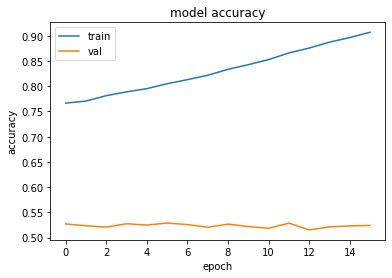

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

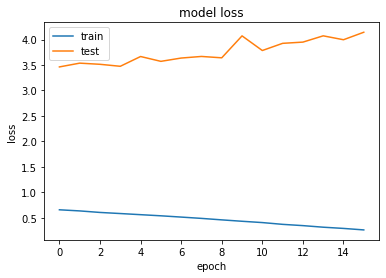

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Check exact match 
def checkStatistic (model, x_eval, y_val):
    res = model.predict(x_eval)

    TN_start = 0 # no answer 
    TP_start = 0 # answer is correct
    FN_start = 0 # there is answer but predict = 0
    FP_start = 0 # wrong answer

    P = 0
    N = 0

    TN_stop = 0 # no answer 
    TP_stop = 0 # answer is correct
    FN_stop = 0 # there is answer but predict = 0
    FP_stop = 0 # wrong answer

    TN_target = 0 # no answer 
    TP_target = 0 # answer is correct
    FN_target = 0 # there is answer but predict = 0
    FP_target = 0 # wrong answer

    for idx in range (res.shape[0]):  
        start_logits = tf.nn.softmax(res[idx][0])
        stop_logits = tf.nn.softmax(res[idx][1])
        target = tf.nn.softmax(res[idx][2])

        start_token = tf.cast(tf.argmax(start_logits), tf.int32)
        stop_token = tf.cast(tf.argmax(stop_logits), tf.int32)
        target = tf.cast(tf.argmax(stop_logits), tf.int32)

        start_gt = y_val[idx][0]
        stop_gt = y_val[idx][1]
        target_gt = y_val[idx][2]

        if start_gt != 0 and stop_gt != 0 and target_gt != 0:
            P += 1
        else:
            N += 1

        # print(start_gt.numpy(), start_token.numpy(), stop_gt.numpy(), stop_token.numpy())

        if start_token == start_gt:
            if start_gt == 0:
                TN_start += 1
            else:
                TP_start += 1
        else:
            if start_gt == 0:
                FP_start +=1 
            else: 
                FN_start +=1 
        
        if stop_token == stop_gt:
            if stop_gt == 0:
                TN_stop += 1
            else:
                TP_stop += 1
        else:
            if stop_gt == 0:
                FP_stop += 1
            else:
                FN_stop += 1
        
        if target == target_gt:
            if target_gt == 0:
                TN_target += 1
            else:
                TP_target += 1
        else:
            if stop_gt == 0:
                FP_target += 1
            else:
                FN_target += 1
    
    print("START:")
    print("TP: ", TP_start)
    print("TN: ", TN_start)
    print("FP: ", FP_start)
    print("FN: ", FN_start)

    print("STOP:")
    print("TP: ", TP_stop)
    print("TN: ", TN_stop)
    print("FP: ", FP_stop)
    print("FN: ", FN_stop)

    print("TARGET:")
    print("TP: ", TP_target)
    print("TN: ", TN_target)
    print("FP: ", FP_target)
    print("FN: ", FN_target)


    print("POS: ", P)
    print("NEG: ", N)

In [ ]:
strategy = get_strategy()
weight_path = '/content/drive/MyDrive/data/models/current/weights-06-0.529.h5'
# weight_path = ''
with strategy.scope():
    myQAModel = create_model(tokenizer)

    if os.path.isfile(weight_path):
        myQAModel.predict([x_train1[0:1], x_train2[0:1], x_train3[0:1]])
        myQAModel.load_weights(weight_path)

    # for layer in myQAModel.bert.layers:
    #     print(layer.name)
    #     for w in layer.weights:
    #         # only train layer_._5 of bert model 
    #         # if 'layer_._5' not in w.name:
    #             # print("Freeze layer ", w.name)
    #         w._trainable = False

    # opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
    opt = tf.keras.optimizers.SGD(learning_rate=0.01)
    lossSCE = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metricSCA = tf.keras.metrics.SparseCategoricalAccuracy()
    myQAModel.compile(optimizer=opt, loss=lossSCE, metrics=[metricSCA], run_eagerly=False)

Running on TPU  ['10.44.151.34:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.44.151.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.44.151.34:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
INFO:absl:TPU has inputs with dynamic shapes:

In [ ]:
checkStatistic(myQAModel, [x_val1, x_val2, x_val3], y_val)

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int32>]


START:
TP:  1098
TN:  2784
FP:  404
FN:  4794
STOP:
TP:  1069
TN:  2780
FP:  389
FN:  4842
TARGET:
TP:  9
TN:  2780
FP:  389
FN:  5902
POS:  5892
NEG:  3188
